In [17]:
## imports
import sys
import os
import numpy as np
import xarray as xr
import cmocean
import matplotlib
import matplotlib.pyplot as plt
import xesmf as xe
import matplotlib.colors as colors
import cartopy
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib import gridspec
import cartopy.mpl.ticker as cticker
import scipy
import scipy.stats
import gsw
from defs import lon180, mmm, stad, maskzonmean

In [18]:
folder = 'Data_processed/'
modellist =  ['GISS2.1G', 'EC-Earth3-LR', 'CCSM4-UoT', 'CCSM4-Utr','CCSM4', 'CESM1.2', 'CESM2', 'IPSL-CM5A', 'IPSL-CM5A2','IPSL-CM6A','MIROC4m','COSMOS', 'HadCM3', 'NorESM1-F','HadGEM3']

In [19]:
#Open sea-ice, area, temperature, salinity, density and stratification index datasets

dsgrid = xr.open_dataset(folder+'1x1grid.nc')
area = dsgrid.area

#Open and calculate MMM sea-ice cover
dsE280 = xr.open_dataset(folder+'MMM_ensemble/E280/SI_100yr.nc')
dsEoi400 = xr.open_dataset(folder+'MMM_ensemble/Eoi400/SI_100yr.nc')

siE280 = mmm(dsE280.si_mean)
siEoi400 = mmm(dsEoi400.si_mean)

#Open salinity
dsE280s = xr.open_dataset(folder+'MMM_ensemble/E280/so_1x1_100yr.nc')
dsEoi400s = xr.open_dataset(folder+'MMM_ensemble/Eoi400/so_1x1_100yr.nc')

#Open temperature
dsE280t = xr.open_dataset(folder+'MMM_ensemble/E280/thetao_1x1_100yr.nc')
dsEoi400t = xr.open_dataset(folder+'MMM_ensemble/Eoi400/thetao_1x1_100yr.nc')

#Open density
dsE280 = xr.open_dataset(folder+'MMM_ensemble/E280/rho_1x1_100yr.nc')
dsEoi400 = xr.open_dataset(folder+'MMM_ensemble/Eoi400/rho_1x1_100yr.nc')

#Open stratification index
dsE280si = xr.open_dataset(folder+'MMM_ensemble/E280/stratindex_1x1_100yr.nc')
dsEoi400si = xr.open_dataset(folder+'MMM_ensemble/Eoi400/stratindex_1x1_100yr.nc')


In [20]:
zmE280 = mmm(dsE280.rho.mean(dim='lon'))
zmEoi400 = mmm(dsEoi400.rho.mean(dim='lon'))
zmrho = zmEoi400-zmE280

zmE280s = mmm(dsE280s.so.mean(dim='lon'))
zmEoi400s = mmm(dsEoi400s.so.mean(dim='lon'))
zmso = zmEoi400s - zmE280s

zmE280t = mmm(dsE280t.thetao.mean(dim='lon'))
zmEoi400t = mmm(dsEoi400t.thetao.mean(dim='lon'))
zmthetao = zmEoi400t - zmE280t

In [21]:
#Calculate high-latitude (>60S) stratification index

In [22]:
stratE280 = dsE280si.rho.where(dsE280si.lat<=-60).weighted(area).mean(dim=['lat','lon'])
stratEoi400 = dsEoi400si.rho.where(dsEoi400si.lat<=-60).weighted(area).mean(dim=['lat','lon'])

print('Absolute MMM high-latitude stratification index anomaly is %.1f kg/m3' %(stratEoi400.mean()-stratE280.mean()))
print('Relative MMM high-latitude stratification index anomaly is %.0f %%' %((stratEoi400.mean()-stratE280.mean())/stratE280.mean()*100))

Absolute MMM high-latitude stratification index anomaly is 1.9 kg/m3
Relative MMM high-latitude stratification index anomaly is 37 %


In [23]:
lat=dsE280s.lat
lon = dsE280s.lon
z = dsE280s.z

coords = xr.Dataset(data_vars = dict(z2D=(["z", "lat"], np.repeat(z.values[:, np.newaxis]/1000, len(lat), axis=1))), coords = dict(z = z.values/1000, lat = lat.values))
coords['lat2D'] = coords.z2D.copy(deep=True)
coords.lat2D[:] = np.transpose(np.repeat(lat.values[:, np.newaxis], len(z), axis=1))

In [24]:
maskso = maskzonmean(dsE280s.so.mean(dim='lon'), dsEoi400s.so.mean(dim='lon'), zmso, 12)
maskthetao = maskzonmean(dsE280t.thetao.mean(dim='lon'), dsEoi400t.thetao.mean(dim='lon'), zmthetao, 12)
maskrho = maskzonmean(dsE280.rho.mean(dim='lon'), dsEoi400.rho.mean(dim='lon'), zmrho, 12)

In [25]:
def siedge(si):
    zm = si.mean(dim='lon')
    edge = zm.where(zm.lat<0,drop=True).where(zm>=15, drop=True).lat.max()
    return (edge.values)

/var/folders/f4/c_hqzq2n50q925l69wbn3_dw0000gn/T/ipykernel_62051/1353344092.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap0 = plt.cm.get_cmap("cmo.thermal",8).copy()
/var/folders/f4/c_hqzq2n50q925l69wbn3_dw0000gn/T/ipykernel_62051/1353344092.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap1 = plt.cm.get_cmap("cmo.balance",10).copy()
/var/folders/f4/c_hqzq2n50q925l69wbn3_dw0000gn/T/ipykernel_62051/1353344092.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.

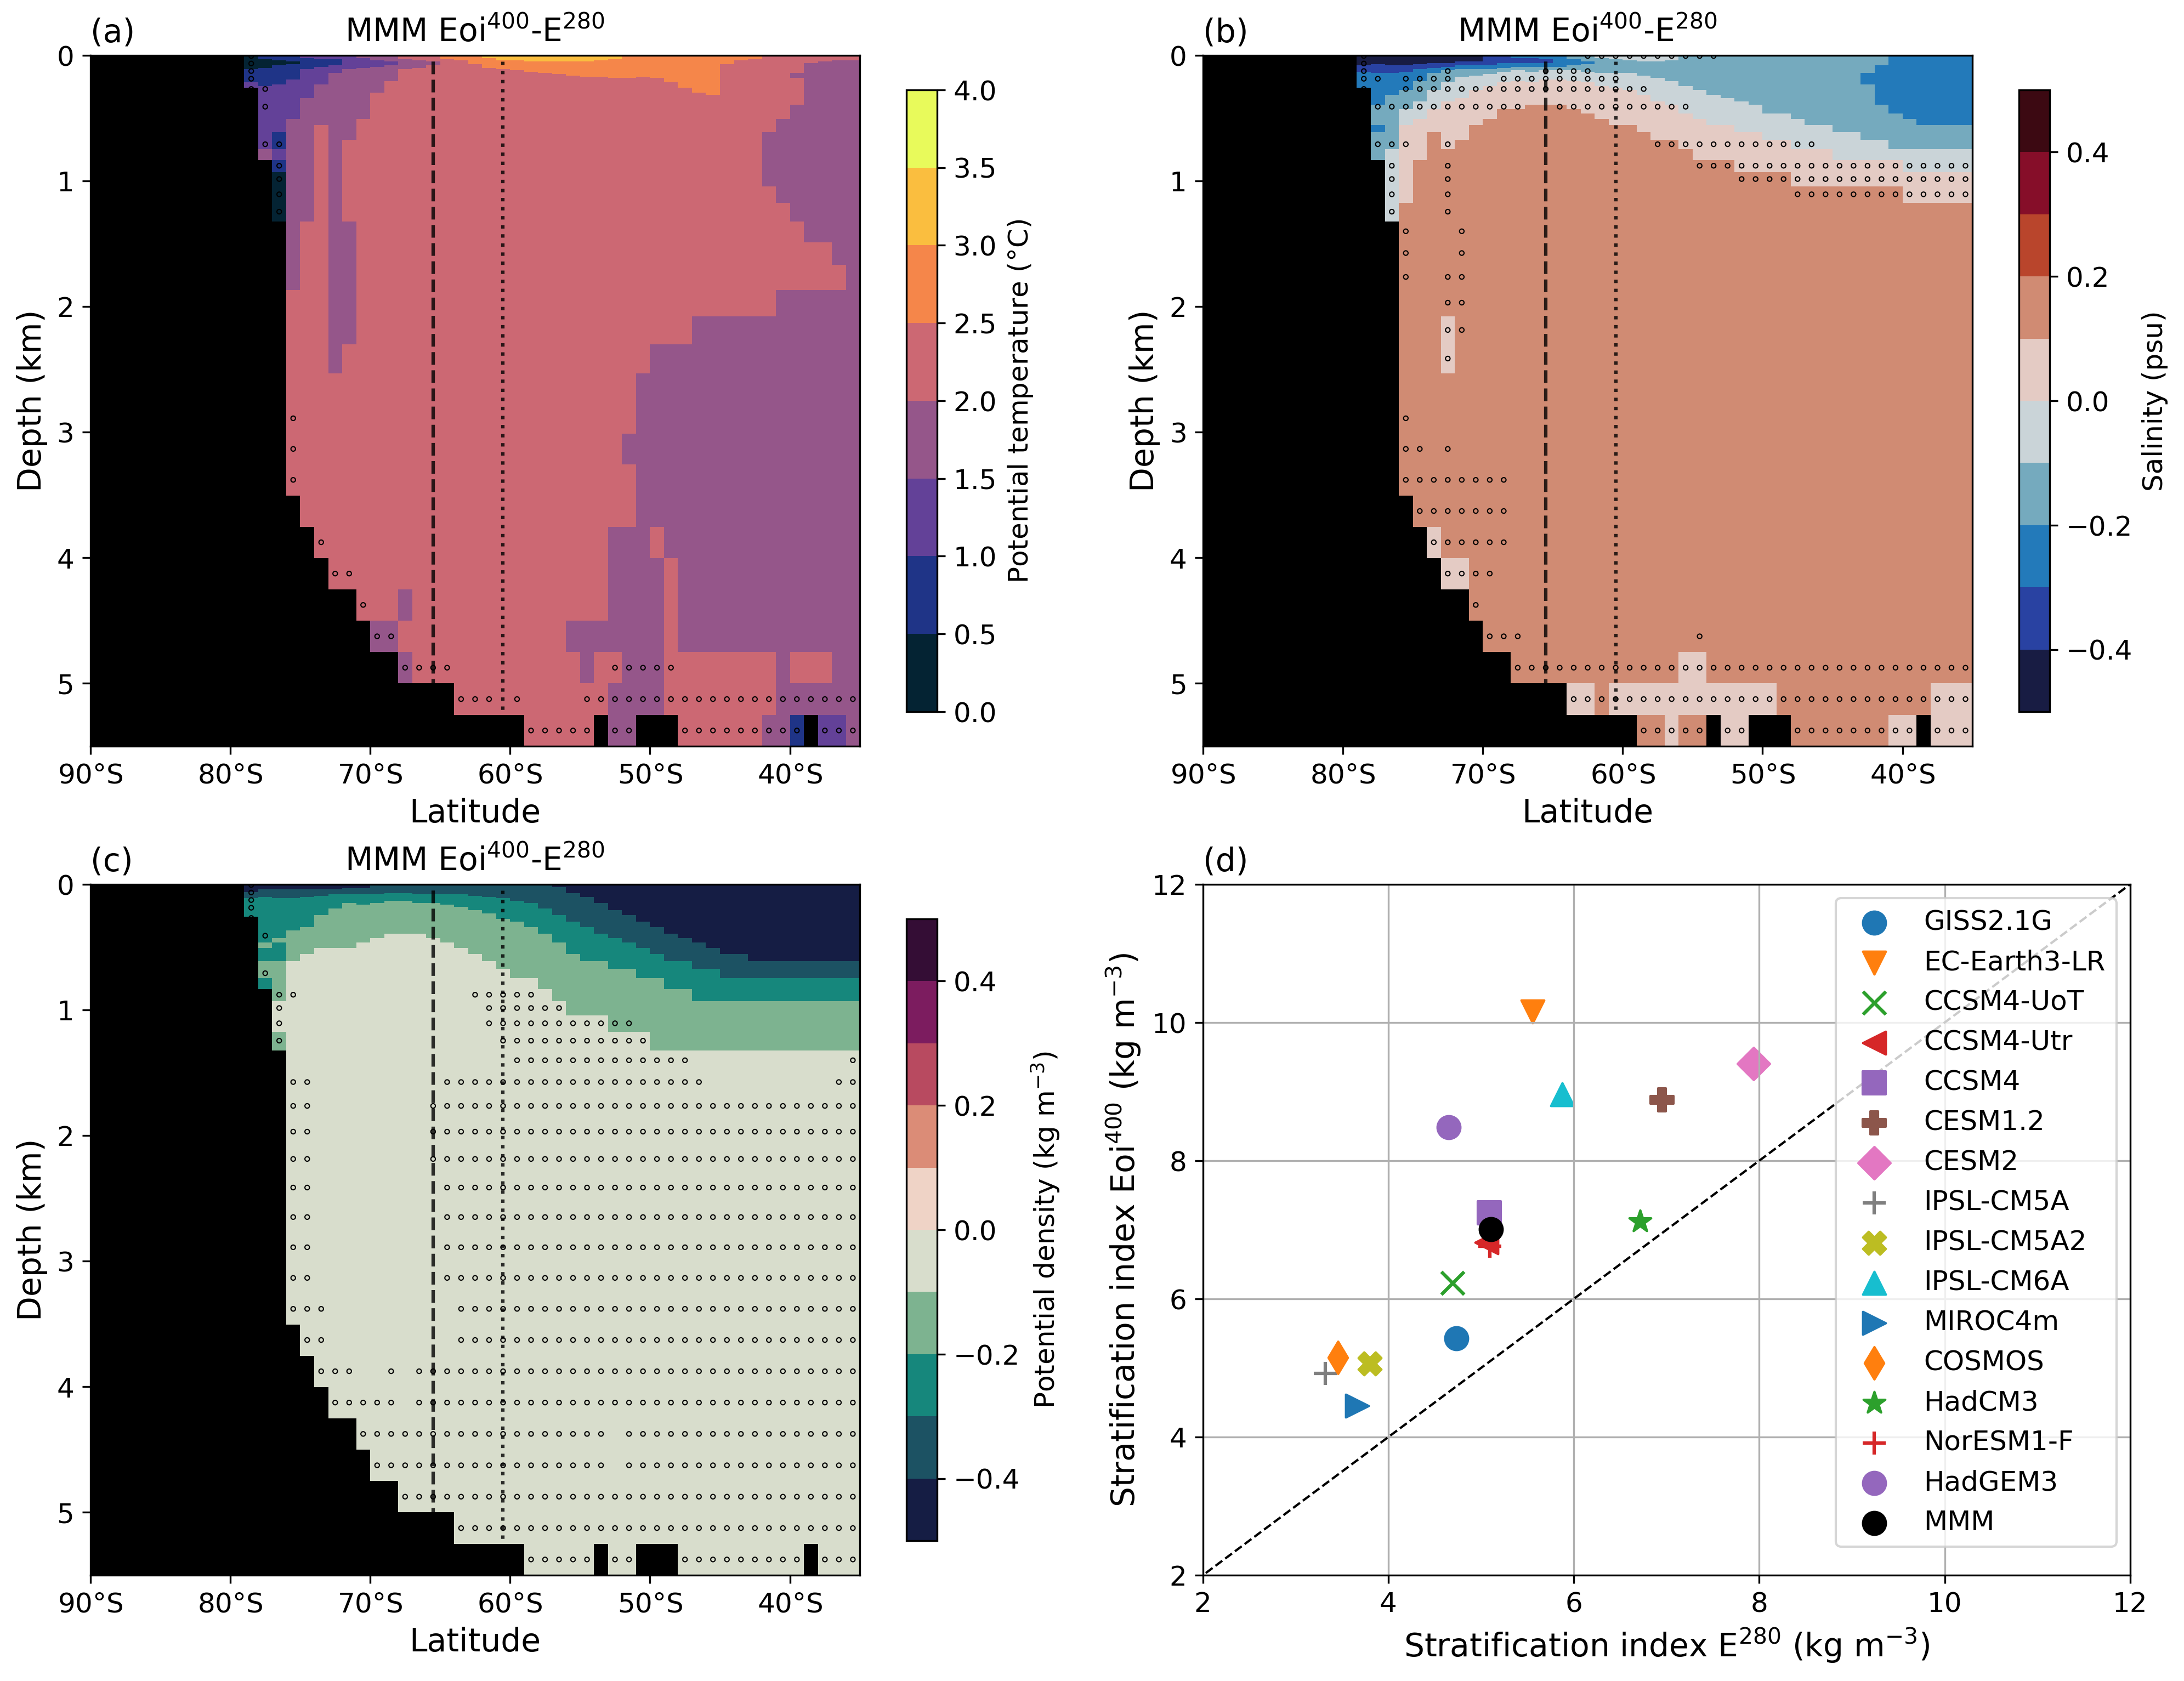

In [26]:
x_pos = np.array([-90,-80,-70,-60,-50,-40])
xtext = ('90$\degree$S', '80$\degree$S', '70$\degree$S', '60$\degree$S', '50$\degree$S', '40$\degree$S')

plt.rcParams['xtick.labelsize']=12
plt.rcParams['ytick.labelsize']=12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 14

## creeer je figuur:
fig = plt.figure(figsize=(16,12), dpi=300)
## creeer je assen. Ik voeg hier de projectie 'plate carree' toe, Cartopy heeft verschillende, bijv EqualEarth
proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=-90.0)

cmap0 = plt.cm.get_cmap("cmo.thermal",8).copy()
cmap0.set_bad('black')

cmap1 = plt.cm.get_cmap("cmo.balance",10).copy()
cmap1.set_bad('black')

cmap2 = plt.cm.get_cmap("cmo.curl",10).copy()
cmap2.set_bad('black')
divnorm = colors.TwoSlopeNorm(vmin=-0.5, vcenter=0, vmax=0.5)

ax = fig.add_subplot(221)
im=ax.pcolormesh(dsEoi400.lat, dsEoi400.z/1000, zmthetao, cmap=cmap0, vmin = 0, vmax = 4)
cs1 = ax.scatter(coords.lat2D.where(maskthetao==0).sel(z=slice(0.8,5.5)), coords.z.where(maskthetao==0).sel(z=slice(0.8,5.5)), s=4, facecolors='none', edgecolors='black', linewidth=0.5)
cs1 = ax.scatter(coords.lat2D.where(maskthetao==0).sel(z=slice(0,0.8))[::6], coords.z.where(maskthetao==0).sel(z=slice(0,0.8))[::6], s=4, facecolors='none', edgecolors='black', linewidth=0.5)
cb = fig.colorbar(im, ax = ax, orientation='vertical', fraction = 0.12, shrink = 0.9)
cb.set_label(label = 'Potential temperature ($\degree$C)', fontsize=12)
ax.axvline(siedge(siE280), linestyle='dotted', color='k',alpha=0.8)
ax.axvline(siedge(siEoi400), linestyle='dashed', color='k', alpha=0.8)
ax.set_title('MMM Eoi$^{400}$-E$^{280}$', loc='center')
ax.set_title('(a)', loc='left')
ax.set_xlabel('Latitude')
ax.set_ylabel('Depth (km)')
ax.set_xlim([-90,-35])
ax.set_ylim(ax.get_ylim()[::-1])
ax.set_xticks(x_pos)
ax.set_xticklabels(xtext)

ax = fig.add_subplot(222)
im=ax.pcolormesh(dsEoi400.lat, dsEoi400.z/1000, zmso, cmap=cmap1, vmin = -0.5, vmax = 0.5)
cs1 = ax.scatter(coords.lat2D.where(maskso==0).sel(z=slice(0.8,5.5)), coords.z.where(maskso==0).sel(z=slice(0.8,5.5)), s=4, facecolors='none', edgecolors='black', linewidth=0.5)
cs1 = ax.scatter(coords.lat2D.where(maskso==0).sel(z=slice(0,0.8))[::6], coords.z.where(maskso==0).sel(z=slice(0,0.8))[::6], s=4, facecolors='none', edgecolors='black', linewidth=0.5)
cb = fig.colorbar(im, ax = ax, orientation='vertical', fraction = 0.12, shrink = 0.9)
cb.set_label(label = 'Salinity (psu)', fontsize=12)
ax.axvline(siedge(siE280), linestyle='dotted', color='k',alpha=0.8)
ax.axvline(siedge(siEoi400), linestyle='dashed', color='k', alpha=0.8)
ax.set_title('MMM Eoi$^{400}$-E$^{280}$', loc='center')
ax.set_title('(b)', loc='left')
ax.set_xlabel('Latitude')
ax.set_ylabel('Depth (km)')
ax.set_xlim([-90,-35])
ax.set_ylim(ax.get_ylim()[::-1])
ax.set_xticks(x_pos)
ax.set_xticklabels(xtext)


ax = fig.add_subplot(223)
im=ax.pcolormesh(dsEoi400.lat, dsEoi400.z/1000, zmrho, cmap=cmap2, norm=divnorm)
cs1 = ax.scatter(coords.lat2D.where(maskrho==0).sel(z=slice(0.8,5.5)), coords.z.where(maskrho==0).sel(z=slice(0.8,5.5)), s=4, facecolors='none', edgecolors='black', linewidth=0.5)
cs1 = ax.scatter(coords.lat2D.where(maskrho==0).sel(z=slice(0,0.8))[::6], coords.z.where(maskrho==0).sel(z=slice(0,0.8))[::6], s=4, facecolors='none', edgecolors='black', linewidth=0.5)
cb = fig.colorbar(im, ax = ax, orientation='vertical', fraction = 0.12, shrink = 0.9)
cb.set_label(label = 'Potential density (kg m$^{-3}$)', fontsize=12)
ax.axvline(siedge(siE280), linestyle='dotted', color='k',alpha=0.8)
ax.axvline(siedge(siEoi400), linestyle='dashed', color='k', alpha=0.8)
ax.set_title('MMM Eoi$^{400}$-E$^{280}$', loc='center')
ax.set_title('(c)', loc='left')
ax.set_xlabel('Latitude')
ax.set_ylabel('Depth (km)')
ax.set_xlim([-90,-35])
ax.set_ylim(ax.get_ylim()[::-1])
ax.set_xticks(x_pos)
ax.set_xticklabels(xtext)

x = np.arange(-200,200,1)
markers = ["o","v","x","<","s","P","D","+","X","^",">","d","*","+","o"]
ax = fig.add_subplot(224)
for j in range(0,len(modellist)):
    scatter = ax.scatter(stratE280[j], stratEoi400[j], s=100, c = 'C'+str(j), label=modellist[j], marker=markers[j])
    
scatter = ax.scatter(stratE280[-2], stratEoi400[-2], s=100, c = 'C'+str(13), marker=markers[-2], alpha=0.5)
scatter = ax.scatter(np.mean(stratE280), np.mean(stratEoi400), s=100, c = 'k', label='MMM', marker='o')

ax.plot(x, x, color='black',linewidth =1, linestyle ='--')  
ax.set_xlabel('Stratification index E$^{280}$ (kg m$^{-3}$)')
ax.set_ylabel('Stratification index Eoi$^{400}$ (kg m$^{-3}$)')
ax.legend(loc='upper right', fontsize=12)
ax.set_ylim([2, 12])
ax.set_xlim([2, 12])
ax.set_title('(d)', loc='left')
ax.grid()
#plt.savefig('Fig3.png', bbox_inches='tight')
plt.show()

## Information for Table 1: Individual model high-latitude stratification index

In [27]:
#SMM, format is E280, E400, Eoi400, Eoi400-E280, E400-E280
smmmodel =  ['CCSM4-UoT', 'CESM2', 'IPSL-CM5A2', 'MIROC4m', 'COSMOS', 'HadCM3', 'NorESM1-F']
dsE280si = xr.open_dataset(folder+'SMM_ensemble/E280/stratindex_1x1_100yr.nc')
dsE400si = xr.open_dataset(folder+'SMM_ensemble/E400/stratindex_1x1_100yr.nc')
dsEoi400si = xr.open_dataset(folder+'SMM_ensemble/Eoi400/stratindex_1x1_100yr.nc')

siE280 = dsE280si.rho.where(dsE280si.lat<=-60).weighted(area).mean(dim=['lat','lon'])
siE400 = dsE400si.rho.where(dsE280si.lat<=-60).weighted(area).mean(dim=['lat','lon'])
siEoi400 = dsEoi400si.rho.where(dsEoi400si.lat<=-60).weighted(area).mean(dim=['lat','lon'])

siE280 = np.round(siE280.values,1)
siE400 = np.round(siE400.values,1)
siEoi400=np.round(siEoi400.values,1)

for i in range(len(smmmodel)):
    print(smmmodel[i]+': %.1f, %.1f, %.1f, %.1f, %.1f' %(siE280[i],siE400[i], siEoi400[i], siEoi400[i]-siE280[i], siE400[i]-siE280[i]))
print('MMM: %.1f, %.1f, %.1f, %.1f, %.1f' %(np.mean(siE280),np.mean(siE400),np.mean(siEoi400), np.round(np.mean(siEoi400),1)-np.round(np.mean(siE280),1), np.round(np.mean(siE400),1)-np.round(np.mean(siE280),1)))

CCSM4-UoT: 4.7, 5.9, 6.2, 1.5, 1.2
CESM2: 7.9, 8.9, 9.4, 1.5, 1.0
IPSL-CM5A2: 3.8, 4.1, 5.1, 1.3, 0.3
MIROC4m: 3.7, 3.7, 4.5, 0.8, 0.0
COSMOS: 3.5, 4.4, 5.2, 1.7, 0.9
HadCM3: 6.7, 7.5, 7.1, 0.4, 0.8
NorESM1-F: 5.1, 5.9, 6.8, 1.7, 0.8
MMM: 5.1, 5.8, 6.3, 1.2, 0.7


In [28]:
#MMM, format is E280, Eoi400, Eoi400-E280
dsE280si = xr.open_dataset(folder+'MMM_ensemble/E280/stratindex_1x1_100yr.nc')
dsEoi400si = xr.open_dataset(folder+'MMM_ensemble/Eoi400/stratindex_1x1_100yr.nc')

siE280 = dsE280si.rho.where(dsE280si.lat<=-60).weighted(area).mean(dim=['lat','lon'])
siEoi400 = dsEoi400si.rho.where(dsEoi400si.lat<=-60).weighted(area).mean(dim=['lat','lon'])

siE280 = np.round(siE280.values,1)
siEoi400=np.round(siEoi400.values,1)

for i in range(len(modellist)):
    print(modellist[i]+': %.1f, %.1f, %.1f' %(siE280[i],siEoi400[i], siEoi400[i]-siE280[i]))
print('MMM: %.1f, %.1f, %.1f' %(np.mean(siE280),np.mean(siEoi400), np.mean(siEoi400-siE280)))

GISS2.1G: 4.7, 5.4, 0.7
EC-Earth3-LR: 5.6, 10.2, 4.6
CCSM4-UoT: 4.7, 6.2, 1.5
CCSM4-Utr: 5.1, 6.8, 1.7
CCSM4: 5.1, 7.2, 2.1
CESM1.2: 7.0, 8.9, 1.9
CESM2: 7.9, 9.4, 1.5
IPSL-CM5A: 3.3, 4.9, 1.6
IPSL-CM5A2: 3.8, 5.1, 1.3
IPSL-CM6A: 5.9, 9.0, 3.1
MIROC4m: 3.7, 4.5, 0.8
COSMOS: 3.5, 5.2, 1.7
HadCM3: 6.7, 7.1, 0.4
NorESM1-F: 5.1, 6.8, 1.7
HadGEM3: 4.7, 8.5, 3.8
MMM: 5.1, 7.0, 1.9


## Figure 4: MOC and stratification index

In [29]:
#Open MOC strengths
dsE280 = xr.open_dataset(folder+'MMM_ensemble/E280/MOC_100yr.nc')
dsEoi400 = xr.open_dataset(folder+'MMM_ensemble/Eoi400/MOC_100yr.nc')

In [30]:
amoc = dsEoi400.amoc-dsE280.amoc
deepmoc = dsEoi400.deepmoc-dsE280.deepmoc
stranom = siEoi400-siE280

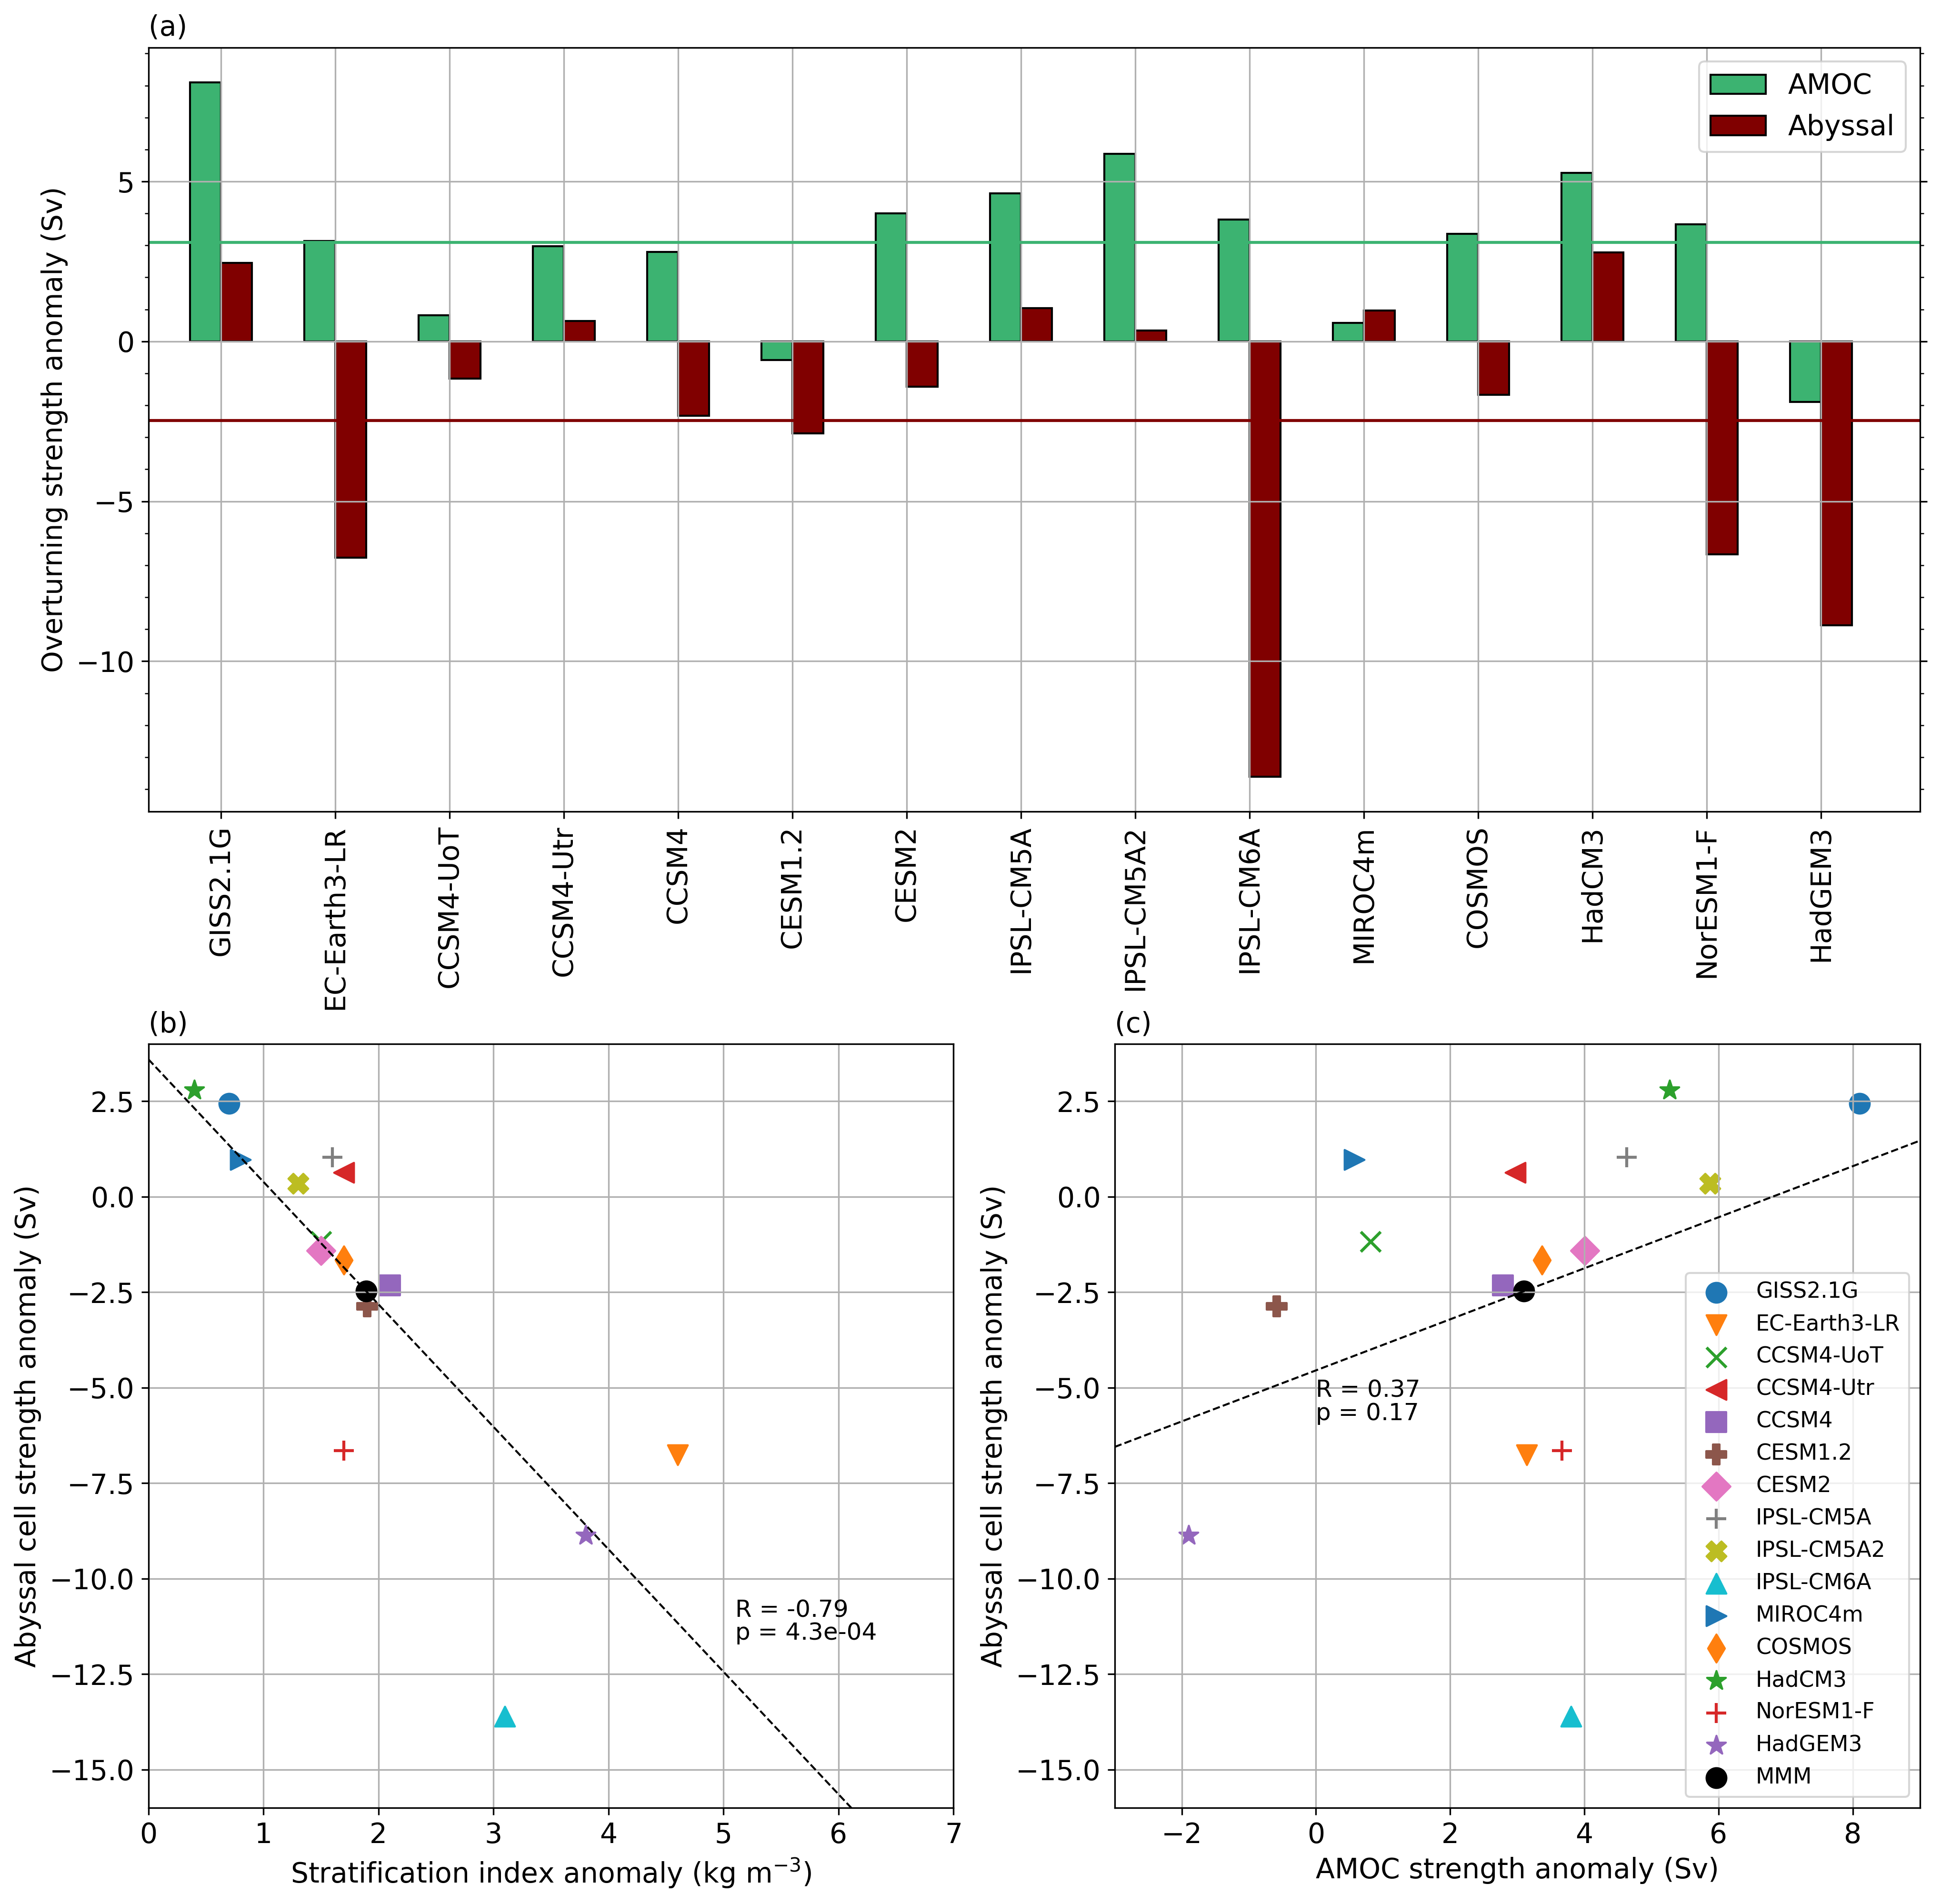

In [31]:
plt.rcParams['xtick.labelsize']=14
plt.rcParams['ytick.labelsize']=14
plt.rcParams['axes.labelsize'] = 14

fig = plt.figure(figsize=(16,16), dpi=300)
spec = fig.add_gridspec(9, 2)


ax = fig.add_subplot(spec[0:4, :])

barWidth = 0.27

# The x position of bars
r1 = np.arange(len(amoc))
r2 = [x + barWidth for x in r1]

ax.plot([-0.5, 15], [np.mean(amoc),np.mean(amoc)], color='mediumseagreen')
ax.plot([-0.5, 15], [np.mean(deepmoc),np.mean(deepmoc)], color='maroon')

ax.bar(r1, amoc,  width = barWidth, color = 'mediumseagreen', edgecolor = 'black', capsize=7, label='AMOC')
ax.bar(r2, deepmoc,  width = barWidth, color = 'maroon', edgecolor = 'black', capsize=7, label='Abyssal')

ax.set_xticks([r+0.5*barWidth for r in range(len(amoc))])
ax.set_xticklabels(modellist, rotation='vertical', fontsize=14)
ax.set_xlim([-0.5,15])
ax.yaxis.get_ticklocs(minor=True)
ax.minorticks_on()
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_tick_params(which='minor', bottom=False)
ax.set_ylabel('Overturning strength anomaly (Sv)', fontsize=14)
ax.legend(fontsize=14)
ax.grid()
ax.set_title(r'(a)', loc='left')

ax = fig.add_subplot(spec[5:, 0:1])

x = np.arange(-200,10,0.1)

markers = ["o","v","x","<","s","P","D","+","X","^",">","d","*","+","*"]

#Perform linear regression between AMOC anomaly and total/overturning OHT anomaly
p = scipy.stats.linregress(stranom, deepmoc)

for j in range(0,len(modellist)):
    scatter = ax.scatter(stranom[j], deepmoc[j], s=100, c = 'C'+str(j), label=modellist[j], marker=markers[j])
scatter = ax.scatter(np.mean(stranom), np.mean(deepmoc), s=100, c = 'k', label='MMM', marker='o')

ax.plot(x, x*p[0]+p[1], color='black',linewidth =1, linestyle ='--')    
ax.text(5.1,-11,'R = %.2f' %(p[2]), fontsize=12)
ax.text(5.1,-11.6, 'p = %.1e' %(p[3]), fontsize=12)

ax.set_title(r'(b)', loc='left')
ax.set_ylim([-16, 4])
ax.set_xlabel('Stratification index anomaly (kg m$^{-3}$)')
ax.set_xlim([0, 7])

#ax.legend(loc='upper right', fontsize=11)
ax.grid()

ax.set_ylabel(r'Abyssal cell strength anomaly (Sv)')


ax = fig.add_subplot(spec[5:, 1:])
#Perform linear regression between AMOC anomaly and total/overturning OHT anomaly
p = scipy.stats.linregress(amoc, deepmoc)

for j in range(0,len(modellist)):
    scatter = ax.scatter(amoc[j], deepmoc[j], s=100, c = 'C'+str(j), label=modellist[j], marker=markers[j])
scatter = ax.scatter(np.mean(amoc), np.mean(deepmoc), s=100, c = 'k', label='MMM', marker='o')

ax.set_ylim([-16, 4])
ax.set_xlim([-3, 9])

ax.plot(x, x*p[0]+p[1], color='black',linewidth =1, linestyle ='--')    
ax.text(0,-5.25,'R = %.2f' %(p[2]), fontsize=12)
ax.text(0,-5.85, 'p = %.2f' %(p[3]), fontsize=12)
ax.set_title(r'(c)', loc='left')
ax.set_xlabel('AMOC strength anomaly (Sv)')
ax.set_ylabel(r'Abyssal cell strength anomaly (Sv)')

ax.legend(loc='lower right', fontsize=11)
ax.grid()

#plt.savefig('Fig4.png', bbox_inches='tight')

In [32]:
print('MMM abyssal cell strength anomaly is %.1f Sv (%.0f %%)' %(np.mean(deepmoc), (np.mean(deepmoc)/np.mean(dsE280.deepmoc)*100)))
print('MMM AMOC strength anomaly is %.1f Sv (%.0f %%)' %(np.mean(amoc), (np.mean(amoc)/np.mean(dsE280.amoc)*100)))

MMM abyssal cell strength anomaly is -2.5 Sv (-22 %)
MMM AMOC strength anomaly is 3.1 Sv (16 %)
